# $Explore$ $Zillow$

### Imports

In [31]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle as w

In [33]:
# wrangel zillow data
df = w.wrangle_single_family_residential()

In [34]:
# shape of data after dropping NAN and Nulls
df.shape

(2140235, 7)

In [35]:
2140235*0.05

107011.75

In [36]:
df.columns

Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips'],
      dtype='object')

In [37]:
df = w.remove_outliers(df,['squarefeet','taxamount','tax_value'])

In [38]:
df.shape

(2057057, 7)

In [39]:
1-(2057057/2140235)

0.03886395652813823

In [40]:
1-(2030511/2140235)

0.0512672673795167

### 2 Make sure to perform a train, validate, test split before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

In [41]:
# Split data to train , test validate, using random state 123
train, validate, test = w.split_data(df)

In [42]:
# shape of train
train.shape

(1151951, 7)

In [43]:
# firs look at train data
train.head()

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips
1032588,4.0,2.5,2453.0,323391.0,1980.0,3355.12,6059.0
1167072,3.0,2.0,1042.0,411045.0,1923.0,4807.42,6037.0
652578,5.0,3.0,2857.0,484821.0,1964.0,6312.92,6037.0
1102488,6.0,3.0,2813.0,215971.0,1924.0,2872.30,6037.0
43744,4.0,1.5,1227.0,379260.0,1961.0,4448.38,6111.0


In [44]:
# stats in zillow train set
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom,1151951.0,3.261111,0.895247,0.00,3.00,3.00,4.00,14.00
bathroom,1151951.0,2.150434,0.839051,0.00,2.00,2.00,3.00,20.00
squarefeet,1151951.0,1759.565230,717.570666,1.00,1245.00,1595.00,2123.00,5057.00
tax_value,1151951.0,375362.129464,265165.470398,22.00,183509.00,316423.00,500511.00,1460470.00
yearbuilt,1151951.0,1960.347539,21.619648,1801.00,1949.00,1958.00,1974.00,2016.00
taxamount,1151951.0,4635.686431,3057.070805,6.34,2475.84,3976.76,6035.03,17607.08
fips,1151951.0,6048.360155,20.465567,6037.00,6037.00,6037.00,6059.00,6111.00


In [45]:
# name of columns in train
train.columns

Index(['bedroom', 'bathroom', 'squarefeet', 'tax_value', 'yearbuilt',
       'taxamount', 'fips'],
      dtype='object')

In [46]:
train.fips.value_counts()

6037.0    767956
6059.0    294794
6111.0     89201
Name: fips, dtype: int64

fips will be taken out because it is a county code 


In [47]:
train['age'] = 2017-train.yearbuilt

In [48]:
# sample= train.sample(1_000, random_state=123)

In [49]:
train.describe()

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
count,1.151951e+06,1.151951e+06,1.151951e+06,1.151951e+06,1.151951e+06,1.151951e+06,1.151951e+06,1.151951e+06
mean,3.261111e+00,2.150434e+00,1.759565e+03,3.753621e+05,1.960348e+03,4.635686e+03,6.048360e+03,5.665246e+01
std,8.952470e-01,8.390511e-01,7.175707e+02,2.651655e+05,2.161965e+01,3.057071e+03,2.046557e+01,2.161965e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,2.200000e+01,1.801000e+03,6.340000e+00,6.037000e+03,1.000000e+00
25%,3.000000e+00,2.000000e+00,1.245000e+03,1.835090e+05,1.949000e+03,2.475840e+03,6.037000e+03,4.300000e+01
50%,3.000000e+00,2.000000e+00,1.595000e+03,3.164230e+05,1.958000e+03,3.976760e+03,6.037000e+03,5.900000e+01
75%,4.000000e+00,3.000000e+00,2.123000e+03,5.005110e+05,1.974000e+03,6.035030e+03,6.059000e+03,6.800000e+01
max,1.400000e+01,2.000000e+01,5.057000e+03,1.460470e+06,2.016000e+03,1.760708e+04,6.111000e+03,2.160000e+02


In [50]:
train[train.tax_value<100]

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
2023880,4.0,2.0,1237.0,22.0,1957.0,1595.67,6037.0,60.0
570504,0.0,0.0,20.0,22.0,2005.0,24.92,6037.0,12.0
1765721,2.0,1.0,943.0,22.0,1949.0,135.93,6037.0,68.0
1509785,0.0,0.0,792.0,23.0,1985.0,99.24,6037.0,32.0
1851761,3.0,3.0,1428.0,22.0,1954.0,6834.33,6037.0,63.0
2125248,3.0,1.0,1128.0,23.0,1925.0,427.61,6037.0,92.0
1259495,0.0,0.0,150.0,22.0,2005.0,24.92,6037.0,12.0
1574215,2.0,1.0,924.0,23.0,1949.0,113.50,6037.0,68.0
764209,0.0,0.0,140.0,22.0,2005.0,24.92,6037.0,12.0
1619739,2.0,1.0,800.0,23.0,1922.0,403.33,6037.0,95.0


In [51]:
# columns of interest as potenital usage in model
columns = ['bedroom', 'bathroom', 'squarefeet', 'yearbuilt',
       'taxamount','tax_value','age']

In [52]:
# correaltion between variables
zillow_corr = train.corr(method='spearman')
zillow_corr

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
bedroom,1.000000,0.619506,0.644076,0.260295,0.425246,0.261996,0.187788,-0.425246
bathroom,0.619506,1.000000,0.810440,0.433123,0.573774,0.432671,0.198521,-0.573774
squarefeet,0.644076,0.810440,1.000000,0.476794,0.510152,0.474157,0.197782,-0.510152
tax_value,0.260295,0.433123,0.476794,1.000000,0.275825,0.976400,0.162982,-0.275825
yearbuilt,0.425246,0.573774,0.510152,0.275825,1.000000,0.273808,0.416903,-1.000000
taxamount,0.261996,0.432671,0.474157,0.976400,0.273808,1.000000,0.093082,-0.273808
fips,0.187788,0.198521,0.197782,0.162982,0.416903,0.093082,1.000000,-0.416903
age,-0.425246,-0.573774,-0.510152,-0.275825,-1.000000,-0.273808,-0.416903,1.000000


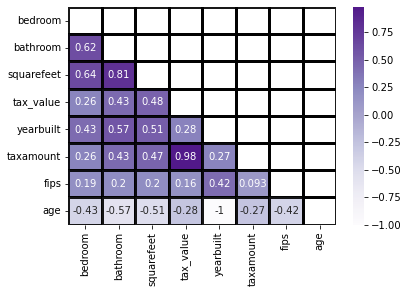

In [53]:
# pass my correlation matrix to Seaborn's heatmap 
kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black'}

sns.heatmap(zillow_corr, cmap='Purples', annot=True, 
            mask=np.triu(zillow_corr), **kwargs)
plt.show()

### outliers Taken out
The strongest correlation is tax_value and taxamount at 0.98 The strongest correlation is squarefeet vs bathrooms at 0.82
* Next strongest is squarefeet vs bedrooms at 0.65
* Next strongest is bathroom vs bedroom at 0.63
* Others above 0.50:
  * yearbuild(age) vs bathrooms at 0.57
  * taxammount vs squarefeet at 0.50
  * year built(age) vs squarefeet at 0.51
The target is tax_value has a strong correlation with taxamount (0.98), and a correlation of (0.50) with squarefeet

### with outliers
The strongest correlation is tax_value and taxamount at 0.98
The strongest correlation is squarefeet vs bathrooms at 0.83

* Next strongest is  squarefeet vs bedrooms at 0.66
* Next  strongest is  bathroom vs bedroom at 0.63
* Others above 0.5:
        * yearbuild(age) vs bathrooms at 0.57
        * taxammount vs squarefeet at 0.52
        * year built(age) vs squarefeet at 0.51
        
The **target is tax_value** has a strong correlation with taxamount (0.98), and a correlation of (0.52) with squarefeet 
        

In [54]:
X = train[[ 'yearbuilt',
       'taxamount','bedroom']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,yearbuilt,15.071644
1,taxamount,3.552628
2,bedroom,15.669824


In [55]:
X = train[['bedroom', 'bathroom', 'squarefeet' ,
       'taxamount','age' ]]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,bedroom,20.357679
1,bathroom,23.650302
2,squarefeet,24.370896
3,taxamount,4.729849
4,age,4.193125


In [56]:
X = train[[ 'squarefeet' ,
       'taxamount','age']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,squarefeet,6.153265
1,taxamount,4.649956
2,age,2.795005


### might use these features for model since the combination had the most independence 
* 'squarefeet' ,'taxamount','bedroom'
* 'squarefeet' ,'taxamount','age'

### Maybe these features but there is a vif score above 5 in (bedroom/bathroom)
* 'squarefeet' , 'taxamount','age', 'bedroom'(7.22)
* 'squarefeet' , 'taxamount','age', 'bathroom'(6.38)

###  * Still need to see which ones have an association with target variable

## After taking outlier out previous groups VIF changed 
    * maybe use taxamount and square feet

### 3.  Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [57]:
# how to create a list from train columns
col = train.columns.to_list()

### reverse the columns
col.reverse()

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1151951 entries, 1032588 to 66871
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedroom     1151951 non-null  float64
 1   bathroom    1151951 non-null  float64
 2   squarefeet  1151951 non-null  float64
 3   tax_value   1151951 non-null  float64
 4   yearbuilt   1151951 non-null  float64
 5   taxamount   1151951 non-null  float64
 6   fips        1151951 non-null  float64
 7   age         1151951 non-null  float64
dtypes: float64(8)
memory usage: 79.1 MB


In [59]:
def plot_variable_pair(df):
    columns = df.columns.to_list()
    for i, col in enumerate(columns):
        sns.lmplot(data=df, x=col, y='tax_value', line_kws={'color':'red'})
        plt.show()

def plot_variable_pair1(df):
    columns = df.columns.to_list()
    for i, col in enumerate(columns):
        subplot_number = i + 1
        plt.subplot(1,4,subplot_number)
        plt.title(col)
        sns.lmplot(data=df, x=df[col], y='tax_value', line_kws={'color':'red'})
        plt.show()

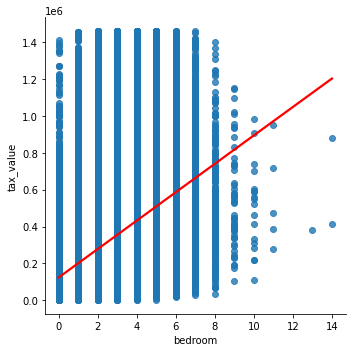

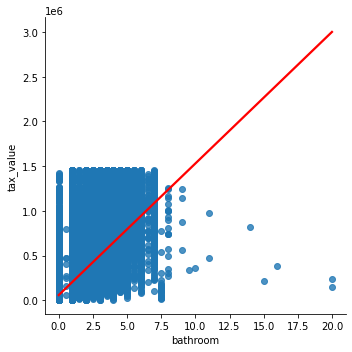

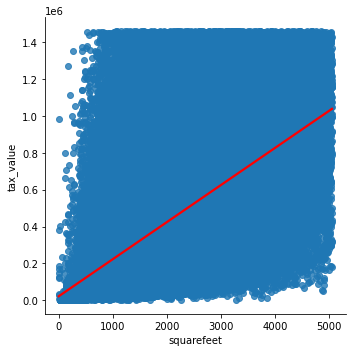

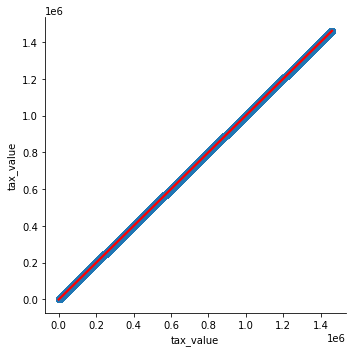

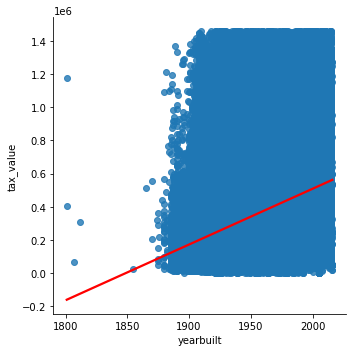

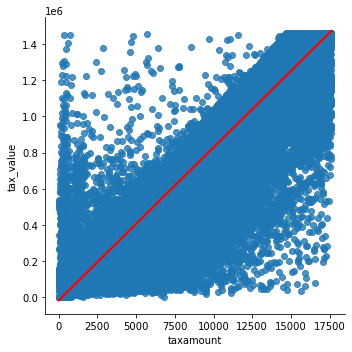

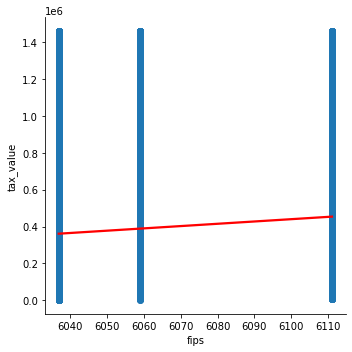

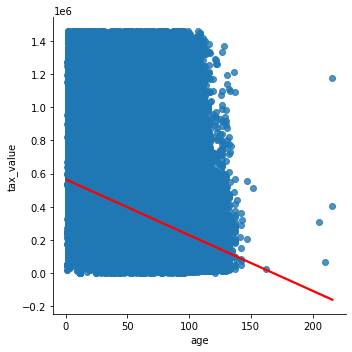

In [60]:
plot_variable_pair(train)

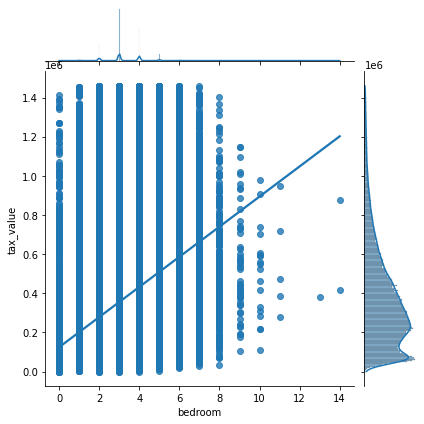

In [61]:
sns.jointplot(data=train, x='bedroom', y='tax_value', kind='reg')

Normal distribution, linear function has a positive slope close to 0.

In [ ]:
sns.jointplot(data=train, x='bathroom', y='tax_value', kind='reg')

normal distribution, slope is positive

In [ ]:
sns.jointplot(data=train, x='squarefeet', y='tax_value', kind='reg')

In [ ]:
Outliers are skewing the data here

In [ ]:
sns.jointplot(data=train, x='yearbuilt', y='tax_value', kind='reg')

line has a slope close to 0

In [ ]:
sns.jointplot(data=train, x='taxamount', y='tax_value', kind='reg')

Strong positive correlation, outliers are present but doent seem to skew at this axis scale

In [ ]:
sns.jointplot(data=train, x='age', y='tax_value', kind='reg')

Slope is close to 0

In [ ]:
sns.pairplot(data=train.drop(columns='fips'),
            corner=True,kind='reg')
plt.show()

### 4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [ ]:
sample.dtypes

In [ ]:
train.fips = train.fips.astype(object)

In [ ]:
train.bedroom = train.bedroom.astype(object)

In [ ]:
train.bathroom = train.bathroom.astype(object)

In [ ]:
sample= train.sample(1_000, random_state=123)

In [ ]:
train.dtypes

In [ ]:
def plot_categorical_and_continuous_vars(df, cat, cont):

    plt.title(cat, cont)
    
    sns.boxplot(x = df[cat], y = df[cont])
    sns.barplot(x = df[cat], y = df[cont])
    sns.violinplot(x=df[cat], y=df[cont])
    
    

In [ ]:
cat_vars = ['bathroom', 'bedroom', 'fips']
cont_vars = ['taxamount', 'tax_value', 'yearbuilt','age']

In [ ]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()


In [ ]:
plot_categorical_and_continuous_vars(sample,cat_vars, cont_vars)

In [ ]:
sample.columns.is_object

In [ ]:
sns.boxplot(x = sample.bedroom, y = sample.tax_value)

In [ ]:
sns.barplot(x = sample.bedroom, y = sample.tax_value)

In [ ]:
sns.violinplot(x=sample.bedroom, y=sample.tax_value)

In [ ]:
plot_categorical_and_continuous_vars(train, 'bedroom', 'tax_value')

In [ ]:
for i, col in enumerate(cols):
    # i starts at 0, but plot nos should start at 1
    subplot_num = i+1
    # Create subplot.
    plt.subplot(1,4,subplot_num)
    # Title with column name.
    plt.title(col)
    # Display histogram for column.
    sns.boxplot(y = '', x = 'species', data = iris)
    # Hide gridlines.
    plt.grid(False)

### 5. Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

In [ ]:
for i in cat_vars:
    corr, p = stats.pearsonr(sample[i], sample.tax_value)
    print(f'{i} correlation {corr}, p-val{p}')

In [ ]:
for i in cat_vars:
    corr, p = stats.spearmanr(sample[i], sample.tax_value)
    print(f'{i} correlation {corr}, p-val{p}')

In [ ]:
for i in cont_vars:
    corr, p = stats.pearsonr(sample[i], sample.tax_value)
    print(f'{i} correlation {corr}, p-val{p}')

In [ ]:
train.bathroom.mean()

In [ ]:
train.bedroom.mean()

In [ ]:
train.head()

In [ ]:
sample.bathroom.dtype

In [ ]:

for i in cont_vars:
    overall_mean = sample[i].mean()
    t, p = stats.ttest_1samp(i,overall_mean )
    

# TEST

In [64]:
train.bathroom.value_counts()

2.00     524448
1.00     230760
3.00     228599
2.50      79042
4.00      37746
1.50      17382
3.50      13510
5.00       8615
4.50       7026
0.00       2297
6.00       1405
5.50        791
7.00        206
6.50         57
7.50         25
8.00         19
0.50          8
9.00          4
1.75          2
20.00         2
11.00         2
9.50          1
10.00         1
16.00         1
15.00         1
14.00         1
Name: bathroom, dtype: int64

In [65]:
train.bedroom.value_counts()

3.0     530814
4.0     338689
2.0     184917
5.0      70866
1.0      12582
6.0       9854
0.0       2356
7.0       1531
8.0        265
9.0         51
10.0        18
11.0         5
14.0         2
13.0         1
Name: bedroom, dtype: int64

In [69]:

one = train[train.bathroom.between(0,1.5,inclusive='both')]

In [70]:
one

,bedroom,bathroom,squarefeet,tax_value,yearbuilt,taxamount,fips,age
43744,4.0,1.5,1227.0,379260.0,1961.0,4448.38,6111.0,56.0
1069458,3.0,1.0,1415.0,195044.0,1938.0,2418.62,6037.0,79.0
1566195,2.0,1.0,852.0,282181.0,1929.0,3638.30,6037.0,88.0
577550,2.0,1.0,1173.0,230816.0,1929.0,2998.59,6037.0,88.0
493817,3.0,1.5,1170.0,230272.0,1964.0,2850.56,6059.0,53.0
...,...,...,...,...,...,...,...,...
151023,2.0,1.0,576.0,178835.0,1924.0,1906.22,6111.0,93.0
1167781,2.0,1.0,1118.0,282764.0,1930.0,3618.13,6037.0,87.0
27260,3.0,1.0,1014.0,186062.0,1955.0,2861.25,6037.0,62.0
90508,4.0,1.0,1644.0,340260.0,1923.0,4086.47,6037.0,94.0


In [72]:
one = train[train.bathroom.between(0,1.5,inclusive='both')]
two = train[train.bathroom.between(1.5,2.5,inclusive='right')]
three = train[train.bathroom.between(2.5,3.5,inclusive='right')]
four = train[train.bathroom.between(3.5,4.5,inclusive='right')]
five = train[train.bathroom.between(4.5,5.5,inclusive='right')]
six = train[train.bathroom.between(6.5,7.5,inclusive='right')]
seven_plus = train[train.bathroom.between(7.5,100,inclusive='right')]

In [ ]:
stats.f_oneway(sdfs,)

In [76]:
stat, pval = stats.levene(one.tax_value,two.tax_value,three.tax_value, four.tax_value, five.tax_value, six.tax_value, seven_plus.tax_value)
pval

0.0

In [75]:
f, p = stats.f_oneway(one.tax_value,two.tax_value,three.tax_value, four.tax_value, five.tax_value, six.tax_value, seven_plus.tax_value)
f, p

(48846.19647023644, 0.0)